# Introduction

# Objective: Cancer is one of the most prevalent diseases causing around 10 million deaths worldwide. Source(https://www.who.int/news-room/fact-sheets/detail/cancer). With the advancements in Deep learning, we can leverage it to detect cancer images from the non cancer ones. The main objective of this competition is to identify metastatic cancer in small image patches taken from pathology scans. 
# Source: Kaggle - https://www.kaggle.com/competitions/histopathologic-cancer-detection
# Metrics: ROC - AUC
# Training Data: 220,025 images
# Test Data : 57,458 images

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import clear_output
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras import optimizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis

# Reading csv files

In [2]:
train_data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

In [3]:
train_data.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [5]:
train_data.shape

(220025, 2)

In [6]:
submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")

In [7]:
submission.shape

(57458, 2)

# A quick exploration on training data - Images and their corresponding labels

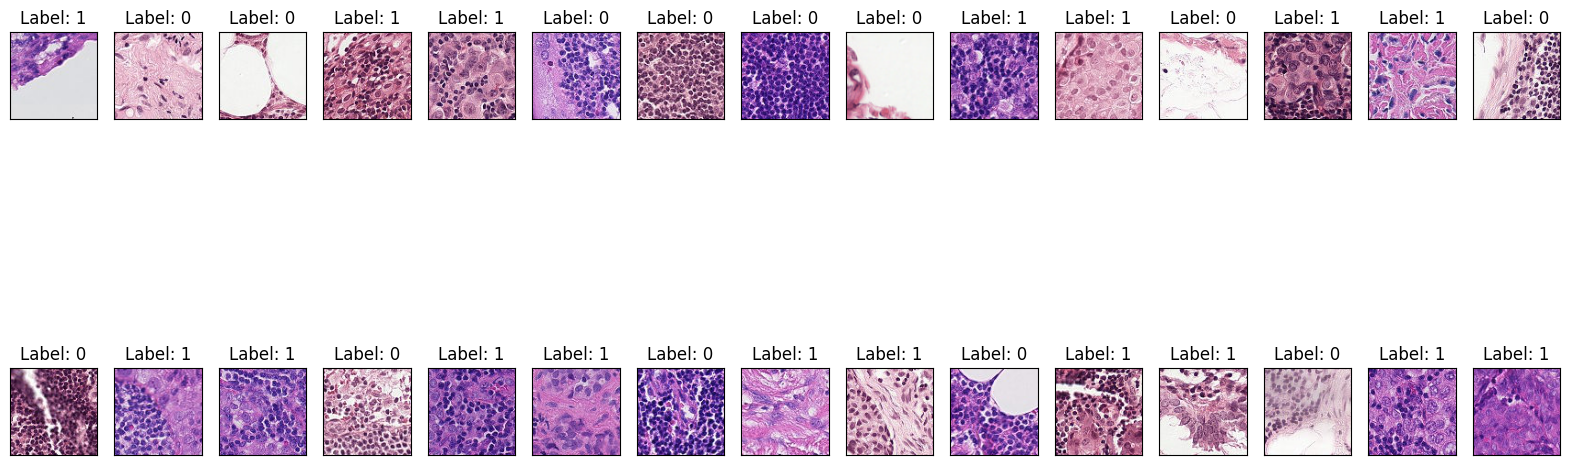

In [8]:
fig = plt.figure(figsize=(20, 8))
train_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")
for idx, img in enumerate(np.random.choice(train_imgs, 30)):
    ax = fig.add_subplot(2, 30//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

# Test data images

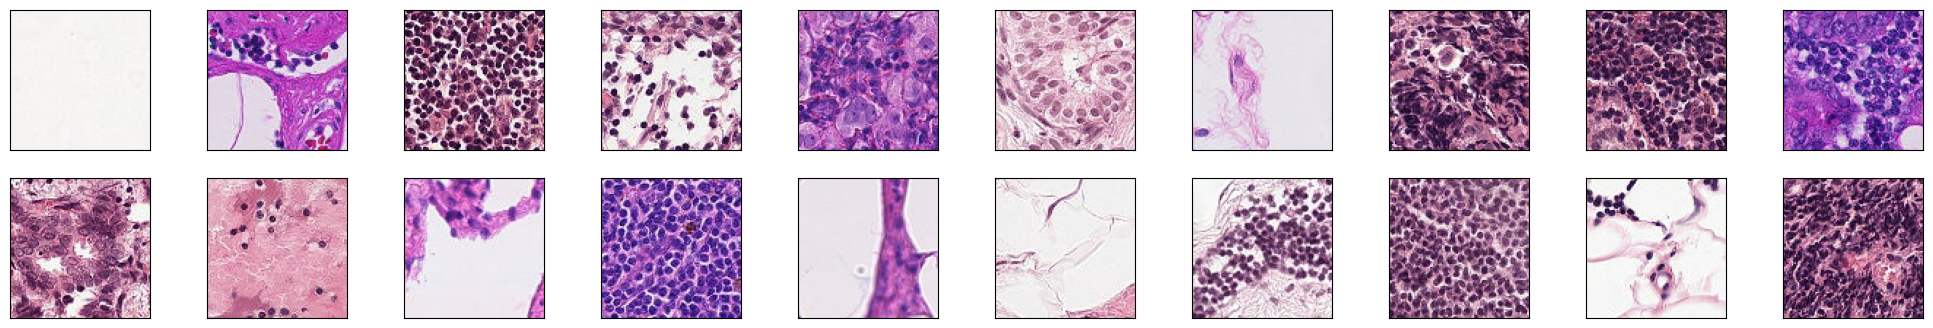

In [9]:
fig = plt.figure(figsize=(25, 4))
test_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")
for idx, img in enumerate(np.random.choice(test_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/histopathologic-cancer-detection/test/" + img)
    plt.imshow(im)


# Modeling

# Setting image size and batch size

In [10]:
IMG_SIZE = 224
BATCH_SIZE = 16

In [11]:
# adding Path to the image
train_data['path'] = '/kaggle/input/histopathologic-cancer-detection/train/' # Adding path to the image id
train_data['id'] =train_data['path']+train_data['id']+'.tif'

# Training Test Split

In [12]:
train_data['label'] = train_data['label'].astype(str)
train, valid = train_test_split(train_data, test_size=0.2)

# Creating an imagedatagenerator for training data and test data

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  vertical_flip = True,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 

# Generating the training images

In [14]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = 'id', 
                                                    y_col = 'label',
                                                    target_size = (IMG_SIZE,IMG_SIZE),
                                                    class_mode = "binary",
                                                    batch_size=BATCH_SIZE,
                                                   shuffle = True)

Found 176020 validated image filenames belonging to 2 classes.


# Generating the validation images

In [15]:
valid_generator = test_datagen.flow_from_dataframe(dataframe = valid,
                                                   x_col = 'id',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH_SIZE,
                                                  shuffle=False)

Found 44005 validated image filenames belonging to 2 classes.


EfficientNetB0:

CNN started with the goal that more the layers are, the better the results would be. ResNet models can be changed from ResNet18 to ResNet200 model just by adding more layers. These models give decent results on benchmark datasets. Unfortunately, there is a cost involved in scaling up these models. There are models which are scaled width wise, there are models which are scaled depth wise.  The authors of EfficientNet proposed a CNN that would scale width, depth or resolution. EfficientNet uses something called as Compound Scaling. This is one of the most powerful CNN models. 

https://medium.com/mlearning-ai/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad


In [16]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  
output = Dense(1, activation='sigmoid')(x)  
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [17]:
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

In [18]:
history = model.fit(train_generator,
                                     steps_per_epoch = train_step_size,
                                     epochs = 5,
                                     validation_data = valid_generator,
                                     validation_steps = valid_step_size,
                                     verbose = 1)

Epoch 1/5


2023-11-30 05:50:03.879792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11001/11001 [==============================] - 1508s 136ms/step - loss: 0.6565 - accuracy: 0.5935 - val_loss: 0.6371 - val_accuracy: 0.5999
Epoch 2/5
11001/11001 [==============================] - 685s 62ms/step - loss: 0.6378 - accuracy: 0.5937 - val_loss: 0.6489 - val_accuracy: 0.5999
Epoch 3/5
11001/11001 [==============================] - 734s 67ms/step - loss: 0.6332 - accuracy: 0.5937 - val_loss: 0.6255 - val_accuracy: 0.5999
Epoch 4/5
11001/11001 [==============================] - 724s 66ms/step - loss: 0.6318 - accuracy: 0.5937 - val_loss: 0.6227 - val_accuracy: 0.5999
Epoch 5/5
11001/11001 [==============================] - 689s 63ms/step - loss: 0.6316 - accuracy: 0.5937 - val_loss: 0.6348 - val_accuracy: 0.5999


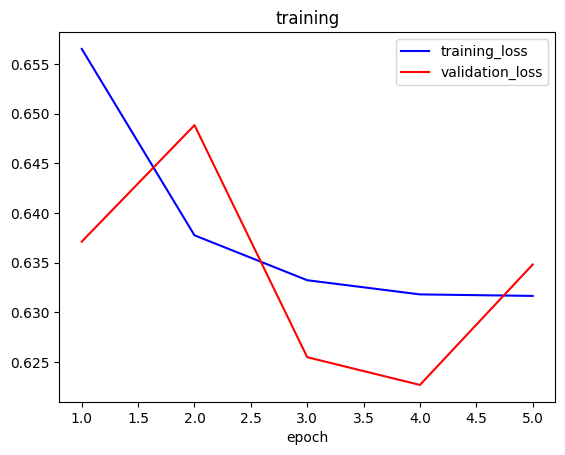

In [19]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.show()

# Applying the same for Test Data

In [20]:
submission['path'] = '/kaggle/input/histopathologic-cancer-detection/test/' # Adding path to the image id
submission['id'] =submission['path']+submission['id']+'.tif'

# Make Predictions on Test Data

In [21]:
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  
test_generator = test_data_generator.flow_from_dataframe(
    dataframe = submission,
    x_col = 'id', 
    target_size=(IMG_SIZE, IMG_SIZE),  
    batch_size=32,
    class_mode=None,  
    shuffle=False  
)

preds = model.predict(test_generator, steps=len(test_generator))

Found 57458 validated image filenames.
1796/1796 [==============================] - 458s 254ms/step


In [22]:
submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
submission['label'] = preds
submission.to_csv("EfficientNetB0Model_Output.csv",index=False)

# Conclusion

# 1. The current model  uses EfficientNetB0 as the base model. EfficientNet uses compound scaling in such a way that there is an uniform scaling of network width, depth and resolution. EfficientNet is scalable till B8 and the image size varies according to the EfficientNet architecture. 
# 2. There can be better architectures such as EfficientNetV2 which is more suitable for faster training and which has a smaller architecture
# 3. The above model is a simple model which leverages deep learning to classify histopathological cancer. 
# 4. The number of epochs is 5. We can also increase the number of epochs as well as use Reduce Learning Rate on plateau, early stopping to ensure that the model converges fast and best optimal solution. 
# 5. We can also leverage ensemble learning to average multiple models and come up with the best solution 